In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [4]:
BASE_DIR = Path.cwd().parent
TEMP_DIR = BASE_DIR / "models" / "baseline_models"
DATA_PATH = BASE_DIR / "data" / "processed" / "labeled_news.csv"
LABEL_MAP_PATH = BASE_DIR / "data" / "processed" / "label_map.json"

In [21]:
result_files = list(TEMP_DIR.glob("results_*.json"))
print(f"Найдено файлов с результатами: {len(result_files)}")

results = {}
for f in result_files:
    model_name = f.stem.replace("results_", "")
    with open(f, "r") as fp:
        results[model_name] = json.load(fp)

Найдено файлов с результатами: 3


In [22]:
df_metrics = pd.DataFrame(results).T
df_metrics = df_metrics.round(4)
print("Сводная таблица метрик:")
display(df_metrics)

Сводная таблица метрик:


,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1
lgbm,0.8259,0.8426,0.8069,0.8229,0.8267,0.8259,0.8253
lr,0.8978,0.8808,0.8692,0.8748,0.8977,0.8978,0.8977
svm,0.9012,0.8850,0.8727,0.8786,0.9011,0.9012,0.9010


<Figure size 1200x600 with 0 Axes>

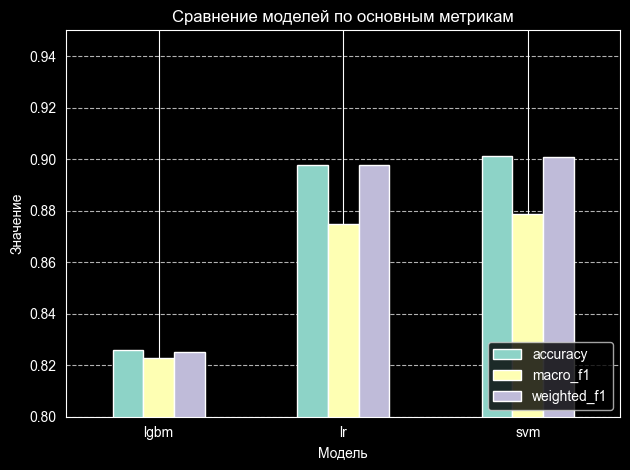

In [23]:
plt.figure(figsize=(12, 6))
metrics_to_plot = ['accuracy', 'macro_f1', 'weighted_f1']
df_metrics[metrics_to_plot].plot(kind='bar', rot=0)
plt.title("Сравнение моделей по основным метрикам")
plt.ylabel("Значение")
plt.xlabel("Модель")
plt.ylim(0.8, 0.95)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [24]:
best_model_name = df_metrics['macro_f1'].idxmax()
best_macro_f1 = df_metrics.loc[best_model_name, 'macro_f1']
print(f"Лучшая модель: {best_model_name} (macro_f1 = {best_macro_f1:.4f})")

Лучшая модель: svm (macro_f1 = 0.8786)


In [17]:
# Загрузка тестовых данных и лучшей модели для детального анализа
import warnings
from sklearn.exceptions import InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

df = pd.read_csv(DATA_PATH)
X = df['lemmatized_text'].values
y = df['label'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

tfidf = joblib.load(TEMP_DIR / "tfidf_vectorizer.pkl")
X_test_vec = tfidf.transform(X_test)

best_model = joblib.load(TEMP_DIR / f"model_{best_model_name}.pkl")
y_pred = best_model.predict(X_test_vec)

In [18]:
target_names = df['category_clean'].unique()
print("Classification report для лучшей модели:")
print(classification_report(y_test, y_pred))

Classification report для лучшей модели:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     43527
           1       0.90      0.88      0.89      5244
           2       0.92      0.91      0.92      7661
           3       0.86      0.89      0.87     15250
           4       0.97      0.98      0.97      5099
           5       0.85      0.85      0.85      8725
           6       0.85      0.82      0.84      1877
           7       0.86      0.88      0.87      9476
           8       0.87      0.84      0.86      4470
           9       0.83      0.79      0.81      5433
          10       0.89      0.82      0.85       651

    accuracy                           0.90    107413
   macro avg       0.88      0.87      0.88    107413
weighted avg       0.90      0.90      0.90    107413



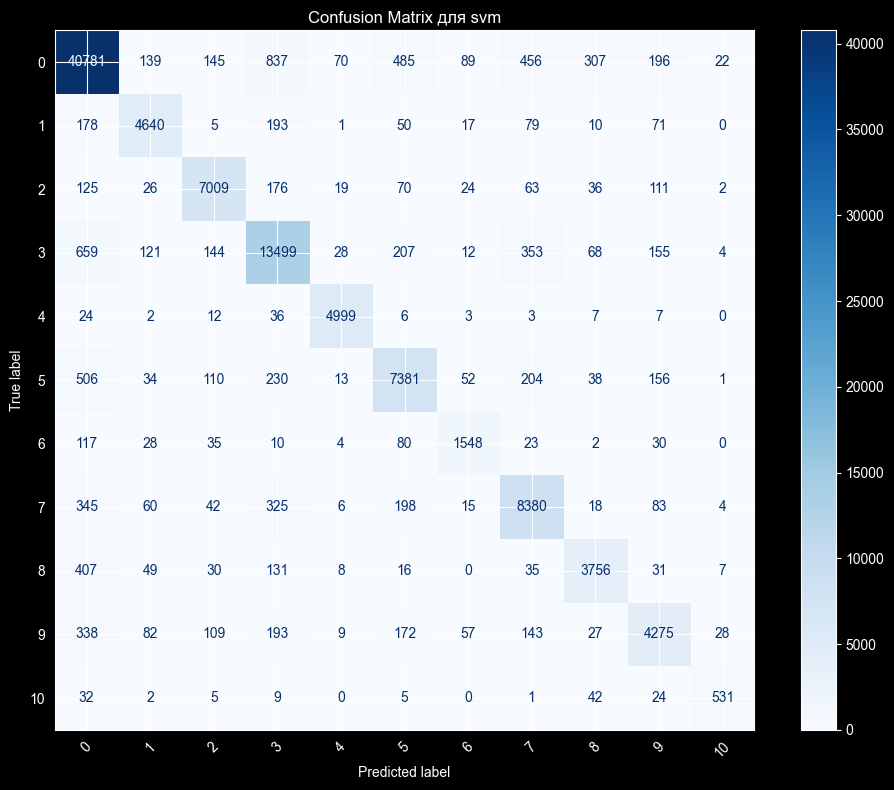

In [19]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title(f"Confusion Matrix для {best_model_name}")
plt.tight_layout()
plt.show()

In [20]:
# Словарь с названиями классов
with open(LABEL_MAP_PATH, 'r', encoding='utf-8') as f:
    label_map = json.load(f)
class_names = {int(k): v for k, v in label_map.items()}

# Получаем названия признаков (слова) из векторайзера
feature_names = tfidf.get_feature_names_out()

coef = best_model.coef_
classes = best_model.classes_

print("ТОП-5 СЛОВА ДЛЯ КАЖДОГО КЛАССА:\n")

for i, class_label in enumerate(classes):
    top_indices = coef[i].argsort()[-5:][::-1]
    top_words = feature_names[top_indices]
    top_scores = coef[i][top_indices]

    print(f"Класс: {class_names[class_label]}")
    for word, score in zip(top_words, top_scores):
        print(f"  {word}: {score:.4f}")
    print()

ТОП-5 СЛОВА ДЛЯ КАЖДОГО КЛАССА:

Класс: Россия: политика
  украина: 51.9766
  режим: 39.6906
  конфликт: 39.1068
  украинский: 38.4574
  вооружённый: 35.9125

Класс: Наука и технологии
  опубликовать журнал: 3.3671
  сообщаться прессрелиз: 3.3285
  москва новость: 3.2303
  сообщаться статья: 3.0655
  сообщать издание: 2.8112

Класс: Культура
  героиня материал: 5.3983
  ной новость: 4.2447
  москва новость: 3.5743
  сен новость: 3.5161
  окт: 3.5055

Класс: Международные отношения
  недостоверный: 3.6737
  телеведущий: 3.6236
  цитата приводить: 3.5136
  реалитишоу: 3.1301
  автор пост: 3.0885

Класс: Спорт
  спортсменка: 2.4695
  спортсмен: 2.3033
  фигурист: 2.0538
  слово приводить: 2.0323
  известный выступление: 1.9930

Класс: Лайфстайл
  туристка: 4.4749
  личный блог: 3.8707
  турист: 3.6917
  беседа: 3.6748
  ипотека: 2.8737

Класс: Регионы
  сообщать: 4.8073
  норильск: 3.7058
  уточнять: 3.5549
  отмечаться: 3.5021
  ранее: 3.3611

Класс: Экономика и бизнес
  роснефть: 3.7803